# Programming Assignment 5 - Logistic Regression 

In the assignment, you will use gradient ascent to find the weights for the logistic regression problem.   

As an example, we will use the widely-used breast cancer data set.  This data set is described here:

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin

Each sample is a collection of features that were manually recorded by a physician upon inspecting a sample of cells from fine needle aspiration.  The goal is to detect if the cells are benign or malignant.

## Step 1:  Getting, preprocessing, and understanding the dataset

### Importing the standard libraries

In [1]:
# Importing important libraries
from sklearn.datasets import load_breast_cancer # taking included data set from Sklearn http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html
from sklearn import preprocessing # preprossing is what we do with the data before we run the learning algorithm
from sklearn.model_selection import train_test_split 
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

### Importing the dataset

In [2]:
# Loading the dataset
cancer = load_breast_cancer()
y = cancer.target
X = cancer.data

In [3]:
# Printing the shape of data (X) and target (Y) values 
print(X.shape)
print(y.shape)

(569, 30)
(569,)


### Data Pre-Processing
#### Splitting the data into train and test before scaling the dataset


In [4]:
# train_test_split to split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

#### Scale the data since we will be using gradient ascent

In [5]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# TODO - Print the shape of x_train and y_train 
print(X_train.shape) # It should print (426, 30)
print(y_train.shape) # It should print (426,)

(426, 30)
(426,)


#### Adding a column of ones to the  matrices $X_{train}$ and  $X_{test}$
After adding a column of ones $X_{train}=\left[\begin{matrix}
1& x^{(1)}_1& x^{(1)}_2 &\ldots& x^{(1)}_d\\
1& x^{(2)}_1& x^{(2)}_2 &\ldots& x^{(2)}_d\\
\vdots & \vdots &\vdots & & \vdots \\
1& x^{(N')}_1& x^{(N')}_2 &\ldots& x^{(N')}_d\\
\end{matrix}\right]$

Similarly for $X_{test}$

In [7]:
# Append a column of ones to x_train 

# Step 1: Create a column vector of ones (i.e. a vector of shape N',1)
ones = np.ones(X_train.shape[0]).reshape((X_train.shape[0], 1))
# Step 2: Append a column of ones in the beginning of x_train
X_train = np.hstack((ones, X_train))

# Now do the same for the test data
# Step 1: Create a column vector of ones (i.e. a vector of shape N",1)
ones = np.ones(X_test.shape[0]).reshape((X_test.shape[0], 1))
# Stemp 2: Append a column of ones in the beginning of x_test
X_test = np.hstack((ones, X_test))


# We can check that everything worked correctly by:
# Printing out the new dimensions
print("The trainng data has dimensions: ", X_train.shape, ". The testing data has dimensions: ",X_test.shape)
# Looking at the first two rows of X_train to check everything worked as expected
print(X_train[0:2])

The trainng data has dimensions:  (426, 31) . The testing data has dimensions:  (143, 31)
[[ 1.         -0.34913849 -1.43851335 -0.41172595 -0.39047943 -1.86366229
  -1.26860704 -0.82617052 -0.95286585 -1.72936805 -0.9415409  -0.86971355
  -1.35865347 -0.83481506 -0.57230673 -0.74586846 -0.65398319 -0.52583524
  -0.94677147 -0.53781728 -0.63449458 -0.54268486 -1.65565452 -0.58986401
  -0.52555985 -1.51066925 -0.89149994 -0.75021715 -0.91671059 -0.92508585
  -0.80841115]
 [ 1.         -0.20468665  0.31264011 -0.13367256 -0.27587995  1.07807258
   0.86354605  0.72631375  0.89844062  1.17876963  1.47437716 -0.04022275
  -0.50962253  0.10947722 -0.13472838 -0.52489487 -0.14934475  0.07460028
   0.23747244 -0.43028253  0.08289146  0.04148684  0.68989862  0.19412774
  -0.05193356  1.12941497  0.92394223  1.22221738  1.43655962  1.14955889
   1.56911143]]


### Understanding the dataset

In [8]:
# Printing the names of all the features
print(cancer.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [9]:
# You can add your own code here to better understand the dataset


# Step 2: Fitting the model
## Implementing Logistic Regression Using Gradient Ascent


 Before writing the gradient ascent code, first write some helpful functions


 
### Sigmoid($z$)
The first function you will write is sigmoid($z$)

sigmoid($z$) takes as input a column vector of real numbers, $z^T = [z_1, z_2, ..., z_{N'}]$, where $N'$ is the number of  examples

It should produce as output a column vector $\left[\frac{1}{1+e^{-z_1}},\frac{1}{1+e^{-z_2}},...,\frac{1}{1+e^{-z_{N'}}}\right]^T$

In [10]:
# TODO - Write the sigmoid function (z can be a scalar or a vector)
def sigmoid(z):
    ## TODO
    sig = 1/(1 + np.exp(-z))
    
    return sig
    ## 

In [11]:
# VERIFY - Sigmoid of 0 should be equal to half
print(sigmoid(0))

0.5


### Initializing ${\bf w}$
For testing the next functions, we create a coefficient vector, ${\bf w}$.
We will initialize the coeffients to be $0$, i.e. ${\bf w}^T = [0,0,\ldots ,0]$ (We could have initialized ${\bf w}$ to any values.)

In [12]:
# Initialize parameters w
w = np.zeros((X_train.shape[1], 1))
print(w.shape)

(31, 1)


### Our hypothesis, $h({\bf x})$
The next  function to write is our hypothesis function. 

For example if our design matrix $X$ consists of single example $X=[1,x_1,x_2,\ldots,x_d]$ and  weights ${\bf w}^T=[w_0,w_2,\ldots, w_d]$, it returns $h({\bf x})=\frac{1}{1+e^{-\left({w_{0}\cdot 1 +w_1\cdot x_1+\cdots w_d\cdot x_d}\right)}}$

If given a  matrix consisting of $N'$ examples 
$X=\left[\begin{matrix}
1& x^{(1)}_1& x^{(1)}_2 &\ldots& x^{(1)}_d\\
1& x^{(2)}_1& x^{(2)}_2 &\ldots& x^{(2)}_d\\
\vdots & \vdots &\vdots & & \vdots \\
1& x^{(N')}_1& x^{(N')}_2 &\ldots& x^{(N')}_d\\
\end{matrix}\right]$
and  weights ${\bf w}^T=[w_0,w_2,\ldots, w_d]$, the function returns a column vector
$[h({\bf x}^{(1)}),h({\bf x}^{(2)},\ldots, h({\bf x}^{(N')}]^T$

In [13]:
# predict the probability that a patient has cancer 
# TODO - Write the hypothesis function 
def hypothesis(X , w):
    #TODO
    h = sigmoid(np.dot(X,w))
    return h
    ##

Before moving on, do a quick check that your function can accpet a matrix as an argument. 

In [14]:
# Compute y_hat using our training examples and w (w is still set to zero).  
# This is just a preliminary test of the hypotheis function
yhat = hypothesis(X_train, w)

# print the sizes of yhat and y as a first check that the function performed correctly
print(yhat.shape) # this should return (426, 1)
print(y_train.shape) # this should return (426,)

(426, 1)
(426,)


### Log-Likelihood Function.
Write the code to calculate the log likelihood function $\ell({\bf w})=
\sum_{i=1}^{N'}y^{(i)}\ln(h({\bf x}^{(i)})) +(1- y^{(i)})\ln(1-h({\bf x}^{(i)}))$

The input is a matrix consisting of $N'$ examples $X=\left[\begin{matrix}
1& x^{(1)}_1& x^{(1)}_2 &\ldots& x^{(1)}_d\\
1& x^{(2)}_1& x^{(2)}_2 &\ldots& x^{(2)}_d\\
\vdots & \vdots &\vdots & & \vdots \\
1& x^{(N')}_1& x^{(N')}_2 &\ldots& x^{(N')}_d\\
\end{matrix}\right]$
and a column vector ${\bf y}^T=[y^{(1)},y^{(2)},\dots,y^{(N')}]$ of labels for $X$.

The output is $\ell({\bf w})$

In [15]:
# TODO - Write the log likelihood function 
def log_likelihood(X , y , w ):
    ##TODO
    y = y.reshape(y.shape[0],1)
    
    log_likelihood = np.sum((y*np.log(hypothesis(X, w))) + ((1- y)*np.log(1 - hypothesis(X, w))))
    ##
    return log_likelihood

Before moving on, do a quick check of your log_likelihood function

In [16]:
# VERIFY - The value should be equal to -295.2806989185367.
print(log_likelihood(X_train,y_train,w))

-295.2806989185367


# Gradient Ascent
Now write the code to perform gradient ascent.  You will use the update rule from the lecture notes.

In [17]:
# TODO - Write the gradient ascent function 
def Logistic_Regresion_Gradient_Ascent(X, y, learning_rate, num_iters):
    # For every 100 iterations, store the log_likelihood for the current w
    # Initializing log_likelihood to be an empty list  
    log_likelihood_values = []
    # Initialize w to be a zero vector of shape x_train.shape[1],1
    w = np.zeros((X.shape[1], 1))
    # Initialize N to the number of training examples
    N = X.shape[0] 
    y = y.reshape(y.shape[0],1)
    ## TODO 
    for i in range(num_iters):
        w = w + (learning_rate/N)* np.dot(X.T, (y - hypothesis(X, w)))
    ##
#         print("Iteration : ",i, log_likelihood(X,y,w))
        if (i % 100) == 0:
            log_likelihood_values.append(log_likelihood(X,y,w))
        
    return w, log_likelihood_values

### After completing the code above, run the following

In [18]:
learning_rate = 0.5
num_iters = 5000 # The number of iteratins to run the gradient ascent algorithm

w, log_likelihood_values = Logistic_Regresion_Gradient_Ascent(X_train, y_train, learning_rate, num_iters)
print(w.T)
# print(log_likelihood_values)

[[-0.1056701  -0.03553097 -0.0536691   0.17221516 -0.31116366 -0.45434972
   2.75131896 -1.30570826 -3.03314808  1.16803283 -0.85636742 -3.72793978
   0.72266145 -0.80953786 -2.47051644 -0.40297532  0.53078335  0.03099043
  -1.27545053  1.31001975  2.1018566  -1.64716699 -2.84431473 -0.20035616
  -1.77971341 -0.16157425  0.73553297 -2.45713669 -1.31520556 -2.99931319
  -0.38232592]]


# Plotting Likelihood v/s Number of Iterations.

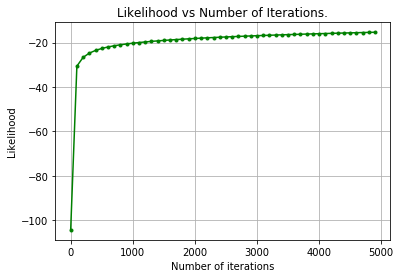

In [19]:
# Run this cell to plot Likelihood v/s Number of Iterations.
iters = np.array(range(0,num_iters,100))
plt.plot(iters,log_likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Likelihood')
plt.title("Likelihood vs Number of Iterations.")
plt.grid()

You should see the likelihood increasing as number of Iterations increase.

### The rest of your code goes here

In [20]:
def calculate_metrics(X_test, y_test, w, threshold):
    
    y_hat = hypothesis(X_test, w)
    y_hat[ y_hat> threshold] = 1
    y_hat[ y_hat< threshold] = 0
    
    TP=0
    FP=0
    FN=0
    TN=0
    
    for i in range(y_test.shape[0]):
        if y_hat[i]==1 and y_test[i]==1 :
            TP +=1
        elif y_hat[i]==0 and y_test[i]==0:
            TN += 1
        elif y_hat[i]==1 and y_test[i]==0:
            FP += 1
        else:
            FN += 1    

    return TP, TN, FP, FN                    
    

# Step 3: Evaluating your model

In [21]:
TP, TN , FP, FN = calculate_metrics(X_test, y_test, w, threshold =0.5)

In [22]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2*precision*recall/(precision+recall)

print("Precision is",precision)
print("Recall is",recall)
print("F1 score is",f1_score)

Precision is 0.9885057471264368
Recall is 0.9662921348314607
F1 score is 0.9772727272727273


In [23]:
confusion_matrix = np.array([[TP, FP], [FN, TN]])
print("Confusion matrix is :\n ",confusion_matrix)

Confusion matrix is :
  [[86  1]
 [ 3 53]]


In [24]:
# Hyperparameters tuning


learning_rates  = np.linspace(0.1, 1, 5)
num_iters = 6000 # The number of iteratins to run the gradient ascent algorithm
log_likelihood_values = []
threshold = 0.5
precisions = []
recalls = []
for learning_rate in learning_rates:
    w, log_likelihood_value = Logistic_Regresion_Gradient_Ascent(X_train, y_train, learning_rate, num_iters)
    log_likelihood_values.append(log_likelihood_value)
    
    TP, TN , FP, FN = calculate_metrics(X_test, y_test, w, threshold =0.5)
    precisions.append(TP/(TP+FP))
    recalls.append(TP/(TP+FN))


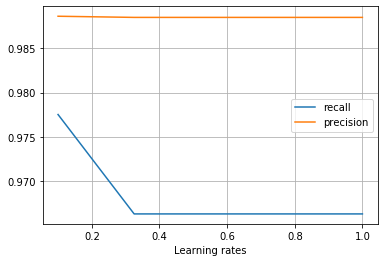

In [25]:

plt.plot(learning_rates, recalls)
plt.plot(learning_rates, precisions)
plt.xlabel('Learning rates')
plt.legend(['recall','precision'])
plt.grid()

In [26]:
learning_rate = 0.1
num_iters = 5000 # The number of iteratins to run the gradient ascent algorithm

w, log_likelihood_value = Logistic_Regresion_Gradient_Ascent(X_train, y_train, learning_rate, num_iters)
log_likelihood_values.append(log_likelihood_value)
    
TP, TN , FP, FN = calculate_metrics(X_test, y_test, w, threshold =0.5)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2*precision*recall/(precision+recall)

print("Precision is",precision)
print("Recall is",recall)
print("F1 score is",f1_score) 

Precision is 0.9886363636363636
Recall is 0.9775280898876404
F1 score is 0.983050847457627


In [27]:
confusion_matrix = np.array([[TP, FP], [FN, TN]])
print("Confusion matrix is :\n ",confusion_matrix)

Confusion matrix is :
  [[87  1]
 [ 2 53]]
